# Cross-correlation

We often encounter the need to match the same pattern in two signals. we may have recorded a whale call at two hydrophones deployed at different locations and want to identify the difference between the time of arrival of the call to these hydrophones. Or we may be receiving the echo time series from a sonar pulse we transmitted, and want to pull out the exact time when the sonar echoes arrive. A widely used method to achieve this to through "[matching filter](https://en.wikipedia.org/wiki/Matched_filter)," or cross-correlation. In the first case, the cross-correlation is between the two hydrophone signals; in the second case, the cross-correlation is between the transmit sonar pulse and the received echo time series. 

Let's start by generating two identical [chirps]((primer_signal-types_chirp)) with a delay between them.

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

from ipywidgets import interactive
import ipywidgets as widgets

FS = 1000
end_time = 1
freq = 100
time = np.linspace(0, end_time, end_time*FS, endpoint=False)

In [2]:
def chirp_short_offset(offset, is_template=False, noise_level=-30):
    """
    noise_level: only used when is_template=False
    """
    chirp_duration = 0.2
    if offset>=0 and offset<=end_time-chirp_duration:
        chirp_time = np.linspace(0, chirp_duration, int(chirp_duration*FS), endpoint=False)
        chirp = signal.chirp(chirp_time, 0, chirp_duration, freq) # zero phase
        A = 1 * signal.windows.tukey(len(chirp), alpha=0.16)

        signal_to_plot = np.zeros(int(end_time*FS))
        signal_to_plot[int(offset*FS):int(offset*FS) + len(chirp)] = A * chirp

        if is_template:
            return signal_to_plot
        else:
            noise_power_lin = 10**(noise_level/10)
            noise_signal = np.random.normal(loc=0, scale=noise_power_lin, size=time.size)
            return signal_to_plot + noise_signal
    else:
        print("Offset out of range")

Below we generated two chirp signals with 0.4 second of time difference between them:

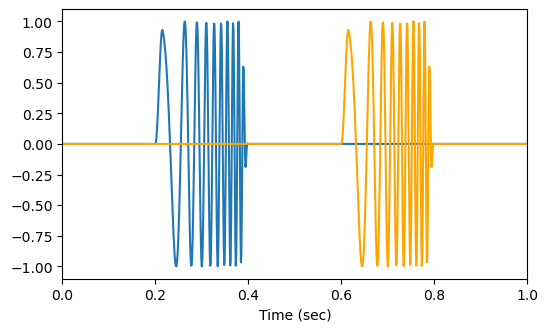

In [3]:
chirp1 = chirp_short_offset(offset=0.2, is_template=True)
chirp2 = chirp_short_offset(offset=0.6, is_template=True)

plt.figure(figsize=(6,3.5))
plt.plot(time, chirp1)
plt.plot(time, chirp2, "orange")
plt.xlim(0, 1)
plt.xlabel("Time (sec)", fontsize=10)
plt.show()

## Finding alignment between signals

To find the alignment between the two chirp signals, intuitively we can try to shift one signal against the other in time and see where the match is the largest, like below.

In [4]:
def plot_shifted_chirp(time_shift):
    chirp1 = chirp_short_offset(offset=0.2, is_template=True)
    chirp2 = chirp_short_offset(offset=0.6+time_shift, is_template=True)

    plt.figure(figsize=(6, 3.5))
    plt.plot(time, chirp1)
    plt.plot(time, chirp2, "orange")
    plt.title("Signal Alignment")
    plt.xlim(0, 1)
    plt.xlabel("Time (sec)", fontsize=10)

out = interactive(
    plot_shifted_chirp,
        time_shift=widgets.FloatSlider(
        value=-0.2,
        min=-0.6,
        max=0.2,
        step=0.01,
        description='Time shift (sec)',
        style={'description_width': 'initial'}
    )
)
display(out)

interactive(children=(FloatSlider(value=-0.2, description='Time shift (sec)', max=0.2, min=-0.6, step=0.01, st…

Using the widget, we can see that the signals line up the best at a time shift of 0.4 second.

## Finding alignment via cross-correlation

How do we quantitatively say what time shift is the best? We can multiply the two signals point-by-point, and sum up the product. This sum represents the similarity between the two signals. We can do this for each possible alignment, and the alignment that gives the highest sum is the best one. This is the idea behind **cross-correlation** between two signals.

For two real continuous signals $f$ and $g$, the cross-correlation is defined as:

$$ R_{fg}(\tau) = \int_{-\infty}^{\infty} f(t) g(t+\tau) dt $$

where $\tau$ is the shift or "lag," and the resulting function is a function of the lag. 

For discrete finite signals of lenght $M$ and $N$, the formulation becomes:

$$R_{fg}[l] = \sum_{k=0}^{M-1}f[k]g[k+l]$$

where $k=-(M-1),...,0, ... (N-1)$.

:::{caution}
Note, by default the `correlate` function computes all possible shifts, thus the output is an array of size $M+N-1$. When a signal is shifted it is padded with zeros to compute the correlation. If one wants to limit to the range to non-padded values, one can use the `mode = 'valid'` option or to align to the first signal the `mode = 'same'` option.
:::

Below, let's put the discrete form in practice to see how the cross-correlation of the two chirps we generated above looks like:

In [5]:
R = signal.correlate(chirp1, chirp2, mode="full")
lags = signal.correlation_lags(chirp1.size, chirp2.size, mode="full")

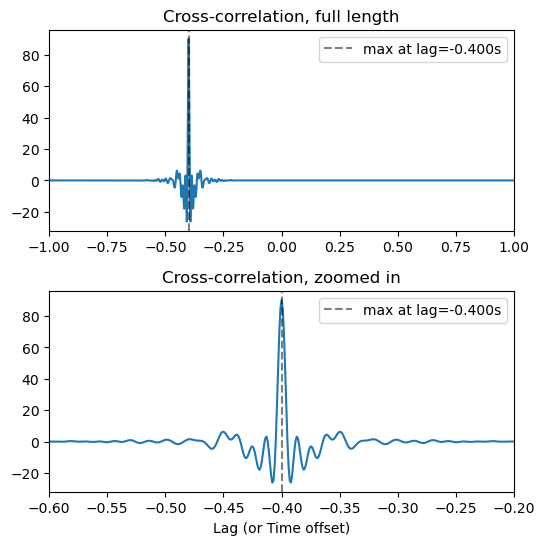

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)
for axx in ax:
    axx.plot(lags/FS, R)
    lag = lags[np.argmax(R)]
    axx.axvline(x=lag/FS, linestyle='dashed', color='k', alpha=0.5, label=f'max at lag={lag/FS:.3f}s')
    axx.legend()
ax[0].set_title("Cross-correlation, full length")
ax[1].set_title("Cross-correlation, zoomed in")
ax[0].set_xlim(-1, 1)
ax[1].set_xlim(-0.6, -0.2)
ax[1].set_xlabel("Lag (or Time offset)", fontsize=10)
plt.show()

We see that the lag with maximum correlation is indeed at -0.4 second, whic is the time difference between the two signals.

To get a better sense of how the above figure comes about, try the widget below that shows the sum of the product of the two signals at different lag:

In [7]:
chirp_clean = chirp_short_offset(offset=0.2, is_template=True)
template_chirp = chirp_short_offset(offset=0.6, is_template=True)  # replica

def plot_cross_correlation(time_shift):

    chirp_move = chirp_short_offset(offset=0.6+time_shift, is_template=True)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
    fig.subplots_adjust(hspace=0.3)
    
    # plot both signals
    ax1.plot(time, chirp_clean, label="Signal to match")
    ax1.plot(time, chirp_move, "orange", label="Replica")
    ax1.set_xlabel("Time")
    ax1.set_xlim(0, 1)
    ax1.set_title("Signals")
    ax1.legend(loc="lower right")

    # cross-correlation
    R = signal.correlate(chirp_clean, template_chirp, mode="full")
    lags = signal.correlation_lags(chirp1.size, chirp_move.size, mode="full")

    # plot cross-correlation
    ax2.plot(lags/FS, R)
    plt.plot(time_shift, R[(len(chirp1)-2) + int(time_shift*FS)], 'ro', markersize=5)
    ax2.set_xlabel("Time Offset")
    ax2.set_xlim(-1, 0.2)
    ax2.set_title("Cross-correlation")
    fig.tight_layout()
    
time_shift_slider = widgets.FloatSlider(
    value=0.2,
    min=-0.6,
    max=0.0,
    step=0.01,
    description='Time shift (sec)',
    style={'description_width': 'initial'},
)

out = interactive(plot_cross_correlation, time_shift=time_shift_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='Time shift (sec)', max=0.0, min=-0.6, step=0.01, sty…

## Finding signals buried in noise

Cross-correlation, or matching filtering, is also a good way of finding signals buried in noise.

Below you can see how cross-correlation can help us pull out the location of a known signal (in this case, the chirp) in a noisy section of recording:

In [8]:
chirp_noisy = chirp_short_offset(offset=0.2, is_template=False, noise_level=-2)  # noisy signal
template_chirp = chirp_short_offset(offset=0.6, is_template=True)  # replica

def plot_cross_correlation_noisy(time_shift):

    chirp_move = chirp_short_offset(offset=0.6+time_shift, is_template=True)  # replica
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
    fig.subplots_adjust(hspace=0.3)
    
    # plot both signals
    ax1.plot(time, chirp_noisy, label="Noisy signal")
    ax1.plot(time, chirp_move, "orange", label="Replica (known signal)")
    ax1.set_xlabel("Time")
    ax1.set_xlim(0, 1)
    ax1.set_title("Signals")
    ax1.legend(loc="lower right")

    # cross-correlation
    R = signal.correlate(chirp_noisy, template_chirp, mode="full")
    lags = signal.correlation_lags(chirp_noisy.size, chirp_move.size, mode="full")

    # plot cross-correlation
    ax2.plot(lags/FS, R)
    plt.plot(time_shift, R[(len(chirp_noisy)-2) + int(time_shift*FS)], 'ro', markersize=5)
    ax2.set_xlabel("Time Offset")
    ax2.set_xlim(-1, 0.2)
    ax2.set_title("Cross-correlation")
    fig.tight_layout()
    
time_shift_slider = widgets.FloatSlider(
    value=0.2,
    min=-0.6,
    max=0.0,
    step=0.01,
    description='Time shift (sec)',
    style={'description_width': 'initial'},
)

out = interactive(plot_cross_correlation_noisy, time_shift=time_shift_slider)
display(out)

interactive(children=(FloatSlider(value=0.0, description='Time shift (sec)', max=0.0, min=-0.6, step=0.01, sty…